In [1]:
import json
import os
import re
import subprocess

import numpy as np
import pandas as pd

import requests

import pyproj as ppj
import rasterio

from PIL import Image

import matplotlib.pyplot as plt

from tqdm import tqdm

## Download chunks

In [2]:
# Create folder for downloaded files, if needed
folder = "../data/swisssurface3d/"
if not os.path.exists(folder):
    os.mkdir(folder)

In [27]:
# Go to
# https://www.swisstopo.admin.ch/en/geodata/height/surface3d-raster.html
# Download links
path = "../data/swisssurface3d/ch.swisstopo.swisssurface3d-raster-3MIyWtPZ.csv"
df = pd.read_csv(path, header=None)
urls = df.iloc[:, 0].to_list()
urls

['https://data.geo.admin.ch/ch.swisstopo.swisssurface3d-raster/swisssurface3d-raster_2021_2615-1092/swisssurface3d-raster_2021_2615-1092_0.5_2056_5728.tif',
 'https://data.geo.admin.ch/ch.swisstopo.swisssurface3d-raster/swisssurface3d-raster_2021_2615-1093/swisssurface3d-raster_2021_2615-1093_0.5_2056_5728.tif',
 'https://data.geo.admin.ch/ch.swisstopo.swisssurface3d-raster/swisssurface3d-raster_2021_2616-1092/swisssurface3d-raster_2021_2616-1092_0.5_2056_5728.tif',
 'https://data.geo.admin.ch/ch.swisstopo.swisssurface3d-raster/swisssurface3d-raster_2021_2616-1093/swisssurface3d-raster_2021_2616-1093_0.5_2056_5728.tif',
 'https://data.geo.admin.ch/ch.swisstopo.swisssurface3d-raster/swisssurface3d-raster_2021_2617-1092/swisssurface3d-raster_2021_2617-1092_0.5_2056_5728.tif',
 'https://data.geo.admin.ch/ch.swisstopo.swisssurface3d-raster/swisssurface3d-raster_2021_2617-1093/swisssurface3d-raster_2021_2617-1093_0.5_2056_5728.tif',
 'https://data.geo.admin.ch/ch.swisstopo.swisssurface3d-ra

In [28]:
tiles = []
for url in tqdm(urls):
    path = folder + os.path.basename(url)
    
    if not os.path.exists(path):
        data = requests.get(url).content
        assert not data.startswith(b"<html>"), path
        with open(path, "wb") as file:
            file.write(data)
            
    pattern = r"swisssurface3d-raster_\d{4}_(\d+)-(\d+)_0"
    match = re.search(pattern, url)
    assert match
    x = int(match.group(1))
    y = int(match.group(2))
    tile = path, x, y
    tiles.append(tile)

100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.69it/s]


In [29]:
ix_min = min(x for _, x, _ in tiles)
ix_max = max(x for _, x, _ in tiles) + 1
iy_min = min(y for _, _, y in tiles)
iy_max = max(y for _, _, y in tiles) + 1
ix_min, ix_max, iy_min, iy_max

(2615, 2619, 1090, 1094)

In [30]:
(ix_max - ix_min) * (iy_max - iy_min)

16

## Stitch TIFF images

In [31]:
# Load raster data
buffer = np.zeros((iy_max - iy_min, ix_max - ix_min, 2000, 2000), dtype=np.float32)
for path, ix, iy in tqdm(tiles):
    with rasterio.open(path) as dataset:
        buffer[iy - iy_min, ix - ix_min] = dataset.read(1)

100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.66it/s]


In [32]:
# Flatten
heightmap = buffer[::-1].transpose(0, 2, 1, 3).reshape(buffer.shape[0] * buffer.shape[2], buffer.shape[1] * buffer.shape[3])

In [33]:
# Bounds coordinates, in LV95
left = ix_min * 1000
right = ix_max * 1000
bottom = iy_min * 1000
top = iy_max * 1000

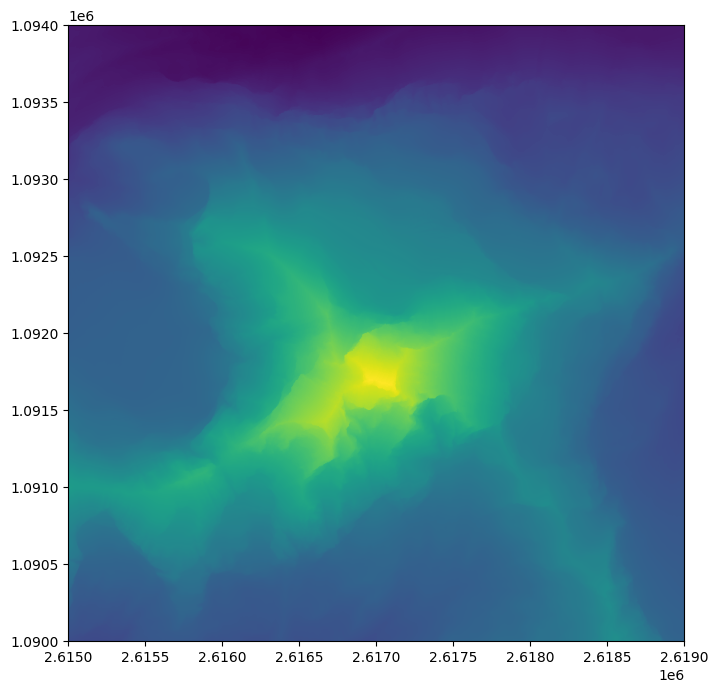

In [34]:
# Show heightmap
# Note: using reduced resolution, for speed
_, ax = plt.subplots(figsize=(8, 8))
ax.imshow(heightmap[::10, ::10], extent=(left, right, bottom, top))
ax.set_aspect("equal")
plt.show()

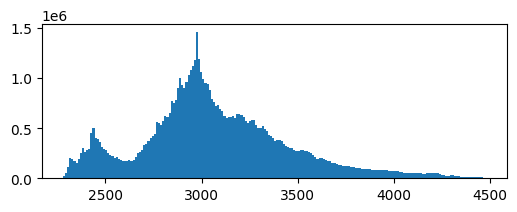

In [35]:
# Overall distribution of altitude data
_, ax = plt.subplots(figsize=(6, 2))
ax.hist(heightmap.reshape(-1), bins=200)
plt.show()

## Export layers as BMP

In [37]:
# Create new folder for temporary files
folder = "../data/tmp/"
assert not os.path.exists(folder)
os.mkdir(folder)

In [38]:
# Thickness of each layer
z_step = 20.0
z_transition = 1.0

# Actual altitude range
z_min = heightmap.min()
z_max = heightmap.max()

# From this point, slice regularly
# Note: make sure we start just above the lowest point
zs = np.arange(z_min + z_step, z_max, z_step)

z_min, z_max, len(zs)

(2278.68, 4477.34, 109)

In [47]:
# Print size, in mm
radius = max(right - left, top - bottom) / 2
print_radius = 50

# Expected resolution (i.e. size of a single pixel), in mm
print_resolution = 0.1

In [49]:
# Make sure we did not mess up the circle thing
assert heightmap.shape[0] == heightmap.shape[1]

In [50]:
# How many heightmap pixels in a single 0.1mm?
heightmap.shape[0] * print_resolution / print_radius

16.0

In [51]:
# Heightmap can be downsampled without noticeable quality loss
image_size = int(2 * print_radius / print_resolution)
image_size

1000

In [52]:
# Downscale, for efficiency
# Note: using PIL, as LANCZOS looks nice
image = Image.fromarray(heightmap)
image.thumbnail((image_size, image_size), Image.Resampling.LANCZOS)
downscaled_heightmap = np.asarray(image)

In [53]:
# How thick (in mm) is a layer, in the print?
z_step / radius * print_radius

0.5

In [54]:
# Export grayscale image for each layer
for iz in tqdm(range(len(zs))):
    z = zs[iz]

    # Renormalize heightmap, so that z is at 0.5, and data is in [0.0, 1.0]
    h = np.tanh((downscaled_heightmap - z) / z_transition)
    h = (0.5 - h * 0.5).clip(0.0, 1.0)

    # Convert to PIL image
    image = (h * 255).clip(0, 255).astype(np.uint8)
    image = Image.fromarray(image)

    # Export as BMP, which is one of the supported format of Potrace
    image.save(folder + f"{iz:04d}.bmp")

100%|████████████████████████████████████████████████████████████████████████████████| 109/109 [00:03<00:00, 28.30it/s]


## Vectorize layers using Potrace

In [56]:
# Make sure you have installed Potrace!
# https://potrace.sourceforge.net/
POTRACE_PATH = "../potrace-1.16.win64/potrace.exe"
assert os.path.exists(POTRACE_PATH)

In [57]:
# Export as SVG (e.g. for Fusion 360)
for iz in tqdm(range(len(zs))):
    # TODO fine-tune
    args = [
        POTRACE_PATH,
        "-b",
        "svg",
        "-o",
        folder + f"{iz:04d}.svg",
        folder + f"{iz:04d}.bmp",
    ]
    result = subprocess.run(args)
    assert result.returncode == 0

100%|████████████████████████████████████████████████████████████████████████████████| 109/109 [00:10<00:00, 10.56it/s]


In [65]:
# Export as GeoJSON
for iz in tqdm(range(len(zs))):
    # TODO fine-tune
    args = [
        POTRACE_PATH,
        "-b",
        "geojson",
        "-o",
        folder + f"{iz:04d}.geojson",
        folder + f"{iz:04d}.bmp",
    ]
    result = subprocess.run(args)
    assert result.returncode == 0

100%|████████████████████████████████████████████████████████████████████████████████| 109/109 [00:09<00:00, 11.05it/s]


## Triangulate layers

In [66]:
path = folder + f"{iz:04d}.geojson"
path

'../data/tmp/0108.geojson'

In [108]:
import json
import shapely

def load_shape(path, *, as_collection=True):

    # Load GeoJSON
    with open(path) as file:
        features = json.load(file)["features"]

    # Convert each feature separately
    shapes = []
    for feature in features:
        assert feature["type"] == "Feature"
        
        # Wrap as Shapely polygon (with holes)
        shape = shapely.geometry.shape(feature["geometry"])
        
        # Clean up geometry, just in case
        shape = shape.buffer(0)

        shapes.append(shape)

    # If requested, convert to a single shapely object
    if as_collection:
        return shapely.geometry.GeometryCollection(shapes)
    return shapes

In [109]:
a = load_shape('../data/tmp/0108.geojson')
b = load_shape('../data/tmp/0107.geojson')

In [114]:
type(a)

shapely.geometry.collection.GeometryCollection

In [113]:
type(b - a)

shapely.geometry.polygon.Polygon

In [115]:
shape = b - a

In [ ]:
# https://github.com/lycantropos/sect

In [116]:
from ground.base import get_context

context = get_context()
Contour = context.contour_cls
Point = context.point_cls
Polygon = context.polygon_cls

def convert_ring(ring):
    return Contour([Point(x, y) for x, y in ring.coords])

def convert_polygon(polygon):
    exterior = convert_ring(polygon.exterior)
    interiors = [convert_ring(interior) for interior in polygon.interiors]
    return Polygon(exterior, interiors)

In [117]:
polygon = convert_polygon(shape)

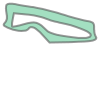

In [119]:
b - a

In [118]:
from sect.triangulation import Triangulation

triangles = Triangulation.constrained_delaunay(polygon, context=context).triangles()

ValueError: Edges of the same polygon should not overlap.

In [ ]:
_, ax = plt.subplots()
for triangle in triangles:
    xs = [point.x for point in triangle.vertices]
    ys = [point.y for point in triangle.vertices]
    ax.fill(xs, ys)
plt.show()

In [123]:
0.5/3

0.16666666666666666

In [124]:
0.05 / 0.033

1.5151515151515151